# Installs / Imports

In [1]:
# install conda (this restarts the colab kernel -- wait until restart before running subsequent blocks)

!pip install condacolab
import condacolab
condacolab.install_miniconda()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
⏬ Downloading https://repo.anaconda.com/miniconda/Miniconda3-py38_4.12.0-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:35
🔁 Restarting kernel...


In [1]:
!pip install geopandas
!pip install rasterio
!pip install wget

/bin/bash: /usr/local/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 15.2 MB/s 
     |████████████████████████████████| 7.8 MB 53.5 MB/s 
     |████████████████████████████████| 2.3 MB 52.0 MB/s 
     |████████████████████████████████| 16.9 MB 502 kB/s 
     |████████████████████████████████| 42 kB 814 kB/s 
     |████████████████████████████████| 12.2 MB 39.6 MB/s 
     |████████████████████████████████| 96 kB 6.2 MB/s 
     |████████████████████████████████| 60 kB 7.0 MB/s 
     |████████████████████████████████| 499 kB 62.0 MB/s 
     |████████████████████████████████| 17.3 MB 804 kB/s 
     |████████████████████████████████| 247 kB 59.3 MB/s 


/bin/bash: /usr/local/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 20.9 MB 69.6 MB/s 
     |████████████████████████████████| 98 kB 8.3 MB/s 
/bin/bash: /usr/local/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=68a0b9850d8d6ab6dcd07d139ae2c18e3818c33dd51ba5017d94678189e65dcb
  Stored in directory: /root/.cache/pip/wheels/bd/a8/c3/3cf2c14a1837a4e04bd98631724e81f33f462d86a1d895fae0
Successfully built wget


In [1]:
import fiona
import rasterio
import wget
import zipfile
import os
import warnings

import geopandas as gpd
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from shapely.geometry import Polygon, Point
from matplotlib import pyplot as plt
from rasterio.plot import show_hist
plt.rcParams['figure.dpi'] = 200

# Data downloading

In [ ]:
# download flood risk data from https://catalog.data.gov/dataset/national-flood-hazard-layer-nfhl

!wget https://gis.fema.gov/NFHL/NFHL_Key_Layers.gdb.zip

/bin/bash: /usr/local/lib/libtinfo.so.6: no version information available (required by /bin/bash)
--2023-01-29 15:25:11--  https://gis.fema.gov/NFHL/NFHL_Key_Layers.gdb.zip
Resolving gis.fema.gov (gis.fema.gov)... 23.2.89.40, 2600:1407:3c00:1486::12b4, 2600:1407:3c00:1485::12b4
Connecting to gis.fema.gov (gis.fema.gov)|23.2.89.40|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14521973992 (14G) [application/zip]
Saving to: ‘NFHL_Key_Layers.gdb.zip’

NFHL_Key_Layers.gdb 100%[===================>]  13.52G   102MB/s    in 1m 56s  

2023-01-29 15:27:08 (119 MB/s) - ‘NFHL_Key_Layers.gdb.zip’ saved [14521973992/14521973992]



In [ ]:
# unzip data

!unzip NFHL_Key_Layers.gdb.zip

/bin/bash: /usr/local/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Archive:  NFHL_Key_Layers.gdb.zip
  inflating: NFHL_Key_Layers.gdb/a00000001.freelist  
  inflating: NFHL_Key_Layers.gdb/a00000001.gdbindexes  
  inflating: NFHL_Key_Layers.gdb/a00000001.gdbtable  
  inflating: NFHL_Key_Layers.gdb/a00000001.gdbtablx  
  inflating: NFHL_Key_Layers.gdb/a00000001.TablesByName.atx  
  inflating: NFHL_Key_Layers.gdb/a00000002.gdbtable  
  inflating: NFHL_Key_Layers.gdb/a00000002.gdbtablx  
  inflating: NFHL_Key_Layers.gdb/a00000003.gdbindexes  
  inflating: NFHL_Key_Layers.gdb/a00000003.gdbtable  
  inflating: NFHL_Key_Layers.gdb/a00000003.gdbtablx  
  inflating: NFHL_Key_Layers.gdb/a00000004.CatItemsByPhysicalName.atx  
  inflating: NFHL_Key_Layers.gdb/a00000004.CatItemsByType.atx  
  inflating: NFHL_Key_Layers.gdb/a00000004.FDO_UUID.atx  
  inflating: NFHL_Key_Layers.gdb/a00000004.freelist  
  inflating: NFHL_Key_Layers.gdb/a00000004.gdbindexes  
  inflating:

In [ ]:
# get US states shape file -- this may be used to only load the data from Florida, for example

!wget https://www.weather.gov/source/gis/Shapefiles/County/s_08mr23.zip

/bin/bash: /usr/local/lib/libtinfo.so.6: no version information available (required by /bin/bash)
wget: /usr/local/lib/libuuid.so.1: no version information available (required by wget)
--2023-01-26 23:55:33--  https://www.weather.gov/source/gis/Shapefiles/County/s_08mr23.zip
Resolving www.weather.gov (www.weather.gov)... 173.223.112.11, 2a02:26f0:6d00:69d::116, 2a02:26f0:6d00:6a7::116
Connecting to www.weather.gov (www.weather.gov)|173.223.112.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20805339 (20M) [application/zip]
Saving to: ‘s_08mr23.zip’

s_08mr23.zip        100%[===================>]  19.84M  66.0MB/s    in 0.3s    

2023-01-26 23:55:33 (66.0 MB/s) - ‘s_08mr23.zip’ saved [20805339/20805339]



In [ ]:
!unzip s_08mr23.zip

/bin/bash: /usr/local/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Archive:  s_08mr23.zip
  inflating: s_08mr23.dbf            
  inflating: s_08mr23.prj            
  inflating: s_08mr23.shp            
  inflating: s_08mr23.shx            


# Data visualization

In [ ]:
fiona.listlayers('/content/NFHL_Key_Layers.gdb/')

# the ArcGis map (https://www.arcgis.com/home/item.html?id=2b245b7f816044d7a779a61a5844be23#overview) uses S_FLD_HAZ_AR, but according to the documentation
# (https://dnr.wi.gov/topic/floodplains/documents/GIS_Submittal_Format.pdf) L_XS_ELEV has more flood categories ...

['S_BFE',
 'S_XS',
 'S_FLD_HAZ_AR',
 'S_GEN_STRUCT',
 'S_FIRM_PAN',
 'L_XS_ELEV',
 'S_LOMR',
 'S_LiMWA',
 'STUDY_INFO']

In [ ]:
# create a custom square polygon around a latlon point and use that as a mask prior to loading data. This does work, but takes the same time (1.5 min) for buffer = 1 and buffer = 0.001
# may be better to use a larger buffer of ~ 1 around one of the supplied latlon values

lat, lon = 32.766259, -79.864261
buffer = 1

lat_point_list = [lat - buffer, lat + buffer, lat - buffer, lat + buffer]
lon_point_list = [lon - buffer, lon + buffer, lon + buffer, lon - buffer]

# creates a square polygon centred on the latlon point
polygon_geom = Polygon(zip(lon_point_list, lat_point_list))
polygon = gpd.GeoDataFrame(index=[0], crs='epsg:4326', geometry=[polygon_geom]) 

image = gpd.read_file('/content/NFHL_Key_Layers.gdb/', layer = "S_FLD_HAZ_AR", ignore_fields = ['DFIRM_ID', 'VERSION_ID', 'FLD_AR_ID', 'STUDY_TYP', 
       'SFHA_TF', 'STATIC_BFE', 'V_DATUM', 'DEPTH', 'LEN_UNIT',
       'VELOCITY', 'VEL_UNIT', 'AR_REVERT', 'AR_SUBTRV', 'BFE_REVERT', 'Shape_Length',
       'Shape_Area', 'DEP_REVERT', 'DUAL_ZONE', 'SOURCE_CIT', 'GFID'],
       mask = polygon)

In [ ]:
# this block of code works, but uses a massive amount of RAM and seems to crash looking at states like Florida

states = gpd.read_file("/content/s_08mr23.shp")

lat, lon = 32.766259, -79.864261

bbox = (
    lat - 1, lon - 1, lat + 1, lon + 1
)

image = gpd.read_file('/content/NFHL_Key_Layers.gdb/', layer = "S_FLD_HAZ_AR", ignore_fields = ['DFIRM_ID', 'VERSION_ID', 'FLD_AR_ID', 'STUDY_TYP', 
       'SFHA_TF', 'STATIC_BFE', 'V_DATUM', 'DEPTH', 'LEN_UNIT',
       'VELOCITY', 'VEL_UNIT', 'AR_REVERT', 'AR_SUBTRV', 'BFE_REVERT', 'Shape_Length',
       'Shape_Area', 'DEP_REVERT', 'DUAL_ZONE', 'SOURCE_CIT', 'GFID'],
       mask = states[states.NAME == "Florida"]) # this is the flood hazard layer, but too big to load into RAM, so drop a bunch of columns and filter by Florida


In [ ]:
states

,STATE,NAME,FIPS,LON,LAT,geometry
0,AL,Alabama,01,-86.826760,32.793540,"MULTIPOLYGON (((-88.11011 30.25891, -88.10638 ..."
1,AR,Arkansas,05,-92.439200,34.899770,"POLYGON ((-91.62986 36.49921, -91.62849 36.499..."
2,AS,American Samoa,60,-170.372150,-14.264860,"MULTIPOLYGON (((-168.14924 -14.53377, -168.148..."
3,AZ,Arizona,04,-111.664570,34.293230,"POLYGON ((-110.49090 37.00361, -110.48750 37.0..."
4,CA,California,06,-119.608180,37.245370,"MULTIPOLYGON (((-118.42620 32.79973, -118.4263..."
5,CO,Colorado,08,-105.547830,38.998550,"POLYGON ((-106.87560 41.00301, -106.85850 41.0..."
6,CT,Connecticut,09,-72.726230,41.621960,"MULTIPOLYGON (((-73.62247 40.98430, -73.62209 ..."
7,DC,District of Columbia,11,-77.014640,38.909320,"MULTIPOLYGON (((-77.03097 38.80826, -77.03110 ..."
8,DE,Delaware,10,-75.505920,38.995590,"MULTIPOLYGON (((-75.22731 38.58854, -75.22744 ..."
9,FL,Florida,12,-82.509340,28.674020,"MULTIPOLYGON (((-81.96339 24.52110, -81.96374 ..."


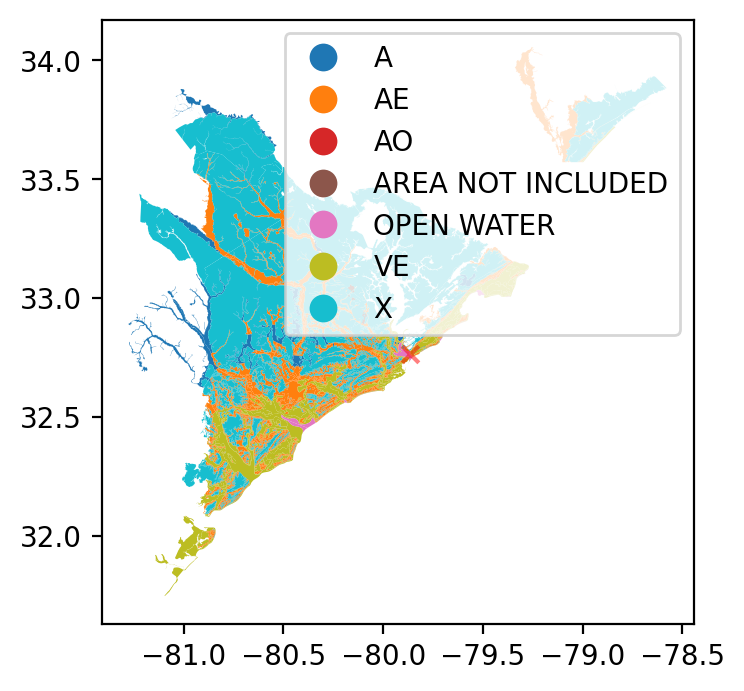

In [ ]:
image.plot(column = "FLD_ZONE", legend = True)
plt.scatter(lon, lat, marker = "x", c = "red", alpha = 0.5)

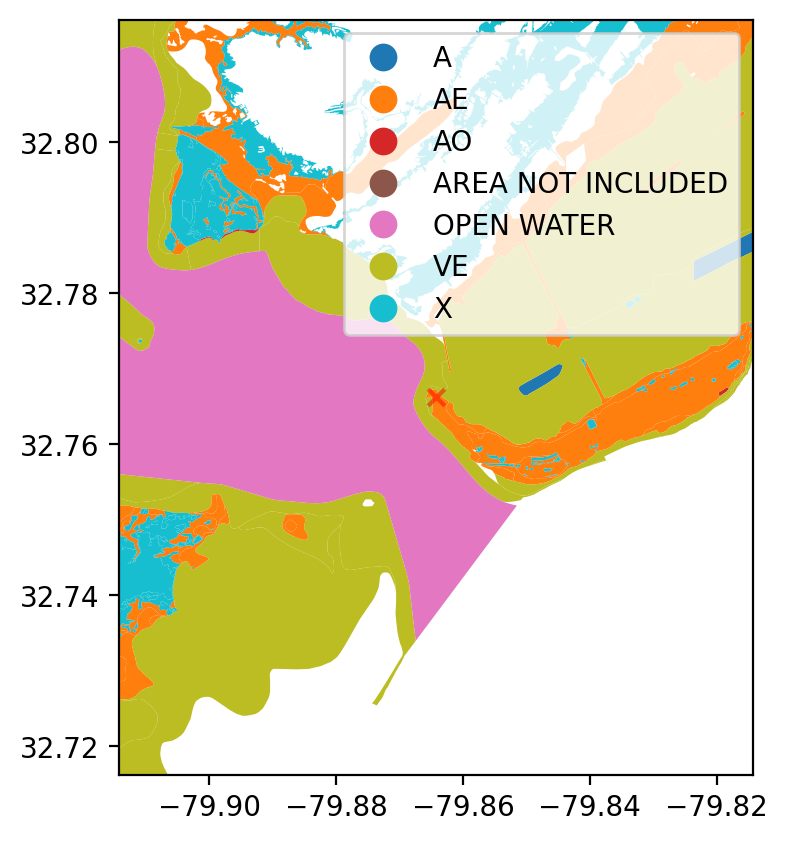

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
image.plot(column = "FLD_ZONE", ax = ax, legend = True)
ax.set_xlim(lon - 0.05, lon + 0.05)
ax.set_ylim(lat - 0.05, lat + 0.05)
plt.scatter(lon, lat, marker = "x", c = "red", alpha = 0.5)

In [ ]:
image.columns

Index(['FLD_ZONE', 'ZONE_SUBTY', 'geometry'], dtype='object')

In [ ]:
image.head()

,FLD_ZONE,ZONE_SUBTY,geometry
0,VE,None,"MULTIPOLYGON (((-79.86448 32.76358, -79.86500 ..."
1,AE,None,"MULTIPOLYGON (((-79.82636 32.76996, -79.82646 ..."
2,VE,None,"MULTIPOLYGON (((-79.73616 32.82291, -79.73565 ..."


In [ ]:
image[image.geometry.contains(Point(lon, lat))] # note lat and lon have swapped places

,FLD_ZONE,ZONE_SUBTY,geometry
1,AE,None,"MULTIPOLYGON (((-79.82636 32.76996, -79.82646 ..."


In [ ]:
# psuedocode:
# 1. pick a random value in the latlon list, produce an image with a buffer of 1 around that latlon
# 2. for each value in the latlon list, if the image contains that latlon value then append the flood risk value and remove latlon from the list
# 3. repeat 1 and 2 until the latlon list is empty, i.e. all latlon values have an assigned flood risk value


# Get EF value from a given lat / long

In [ ]:
lat, lon = 32.766259, -79.864261
buffer = 1

lat_point_list = [lat - buffer, lat + buffer, lat - buffer, lat + buffer]
lon_point_list = [lon - buffer, lon + buffer, lon + buffer, lon - buffer]

# creates a square polygon centred on the latlon point
polygon_geom = Polygon(zip(lon_point_list, lat_point_list))
polygon = gpd.GeoDataFrame(index=[0], crs='epsg:4326', geometry=[polygon_geom]) 

image = gpd.read_file('/content/NFHL_Key_Layers.gdb/', layer = "S_FLD_HAZ_AR", ignore_fields = ['DFIRM_ID', 'VERSION_ID', 'FLD_AR_ID', 'STUDY_TYP', 
       'SFHA_TF', 'STATIC_BFE', 'V_DATUM', 'DEPTH', 'LEN_UNIT',
       'VELOCITY', 'VEL_UNIT', 'AR_REVERT', 'AR_SUBTRV', 'BFE_REVERT', 'Shape_Length',
       'Shape_Area', 'DEP_REVERT', 'DUAL_ZONE', 'SOURCE_CIT', 'GFID'],
       mask = polygon)

In [ ]:
image[image.geometry.contains(Point(lon, lat))] # note lat and lon have swapped places

In [ ]:
df = pd.DataFrame([[32.76, -79.88], [32.78, -79.84], [28.985040, -80.899958], [29.000633, -80.914141], [29.129895, -80.971960], [35.455207, -76.023086], [28.157927, -80.587846], [35.450636, -76.172609], [35.111908, -75.967845], [32.766259, -79.864261]]) 

df.rename(columns = {list(df)[0]: 'lat'}, inplace = True)
df.rename(columns = {list(df)[1]: 'lon'}, inplace = True)

df["FLD_ZONE"] = "tbd"
df["ZONE_SUBTY"] = "tbd"

In [ ]:
def lat_lon_to_flood_risk(df):
    """
    A simple function that takes the latlon values in the supplied dataframe and gets the flood risk value if it is located within the image
    """

    flood_risk = image[image.geometry.contains(Point(df.lon, df.lat))][["FLD_ZONE", "ZONE_SUBTY"]]

    if flood_risk.empty:
        return pd.Series(df[["FLD_ZONE", "ZONE_SUBTY"]].values.flatten())
    else:
        return pd.Series(flood_risk[["FLD_ZONE", "ZONE_SUBTY"]].values.flatten())

In [ ]:
df.rename(columns = {list(df)[0]: 'lat'}, inplace = True)
df.rename(columns = {list(df)[1]: 'lon'}, inplace = True)

df["FLD_ZONE"] = "tbd"
df["ZONE_SUBTY"] = "tbd"


counter = 0

while df["FLD_ZONE"].str.contains("tbd").any():
    counter += 1
    if counter >= 10:
        break

    lat, lon = df[df["FLD_ZONE"] == "tbd"].iloc[0].lat, df[df["FLD_ZONE"] == "tbd"].iloc[0].lon

    # buffer of 1 degree
    buffer = 2

    lat_point_list = [lat - buffer, lat + buffer, lat - buffer, lat + buffer]
    lon_point_list = [lon - buffer, lon + buffer, lon + buffer, lon - buffer]

    # creates a square polygon centred on the latlon point
    polygon_geom = Polygon(zip(lon_point_list, lat_point_list))
    polygon = gpd.GeoDataFrame(index=[0], crs='epsg:4326', geometry=[polygon_geom]) 

    image = gpd.read_file('/content/NFHL_Key_Layers.gdb/', layer = "S_FLD_HAZ_AR", ignore_fields = ['DFIRM_ID', 'VERSION_ID', 'FLD_AR_ID', 'STUDY_TYP', 
        'SFHA_TF', 'STATIC_BFE', 'V_DATUM', 'DEPTH', 'LEN_UNIT',
        'VELOCITY', 'VEL_UNIT', 'AR_REVERT', 'AR_SUBTRV', 'BFE_REVERT', 'Shape_Length',
        'Shape_Area', 'DEP_REVERT', 'DUAL_ZONE', 'SOURCE_CIT', 'GFID'],
        mask = polygon)
    
    df[["FLD_ZONE", "ZONE_SUBTY"]] = df.apply(lat_lon_to_flood_risk, axis = 1)

    print(df["FLD_ZONE"].str.contains("tbd").sum())

    
    


4


KeyboardInterrupt: ignored

In [ ]:
df

,lat,lon,FLD_ZONE,ZONE_SUBTY
0,32.760000,-79.880000,OPEN WATER,None
1,32.780000,-79.840000,VE,None
2,28.985040,-80.899958,X,AREA OF MINIMAL FLOOD HAZARD
3,29.000633,-80.914141,AE,None
4,29.129895,-80.971960,AE,None
5,35.455207,-76.023086,AE,None
6,28.157927,-80.587846,X,AREA OF MINIMAL FLOOD HAZARD
7,35.450636,-76.172609,AE,None
8,35.111908,-75.967845,AE,None
9,32.766259,-79.864261,AE,None


# Repeat above but for Haiti

# Turn it into a useable function

In [ ]:
def latlon_to_floodrisk(input_df: pd.core.frame.DataFrame, buffer: float = 1) -> pd.core.frame.DataFrame:
    def get_flood_risk(df):
        """
        A simple function that takes the latlon values in the supplied dataframe and gets the flood risk value if it is located within the image
        """

        # add a line of code here that checks whether the latlon is within the masking polygon. if it is, but there is no flood risk value, then return a "no value"

        flood_risk = image[image.geometry.contains(Point(df.lon, df.lat))][["FLD_ZONE", "ZONE_SUBTY"]]

        if polygon_geom.contains(df.point):
            if flood_risk.empty:
                return pd.Series(["no_value", "no_value"])
            else:
                return pd.Series(flood_risk[["FLD_ZONE", "ZONE_SUBTY"]].values.flatten())
        else:
            return pd.Series(df[["FLD_ZONE", "ZONE_SUBTY"]].values.flatten())

    def latlon_to_point(df):
        return Point(df.lon, df.lat)

    df = input_df.copy()

    df.rename(columns = {list(df)[0]: 'lat'}, inplace = True)
    df.rename(columns = {list(df)[1]: 'lon'}, inplace = True)

    df["FLD_ZONE"] = "tbd"
    df["ZONE_SUBTY"] = "tbd"
    df["point"] = df.apply(latlon_to_point, axis = 1) # create shapely latlon points

    iterations = 0

    while df["FLD_ZONE"].str.contains("tbd").any():
        print(iterations)
        print("Values left to compute: ", df["FLD_ZONE"].str.contains("tbd").sum())
        iterations += 1

        # choose the first row that has not yet been assigned a flood risk value as the centroid when loading the image
        # this choice can be optimized by more smartly choosing the centroid, e.g. by picking a centroid which has most points surrounding it
        lat, lon = df[df["FLD_ZONE"] == "tbd"].iloc[0].lat, df[df["FLD_ZONE"] == "tbd"].iloc[0].lon

        # buffer of 1 degree

        lat_point_list = [lat - buffer, lat - buffer, lat + buffer, lat + buffer]
        lon_point_list = [lon - buffer, lon + buffer, lon + buffer, lon - buffer]

        # creates a square polygon centred on the latlon point
        polygon_geom = Polygon(zip(lon_point_list, lat_point_list))
        polygon = gpd.GeoDataFrame(index=[0], crs='epsg:4326', geometry=[polygon_geom]) 

        # clear previous image from RAM
        image = None

        # load image 
        image = gpd.read_file('./NFHL_Key_Layers.gdb/', layer = "S_FLD_HAZ_AR", ignore_fields = ['DFIRM_ID', 'VERSION_ID', 'FLD_AR_ID', 'STUDY_TYP', 
            'SFHA_TF', 'STATIC_BFE', 'V_DATUM', 'DEPTH', 'LEN_UNIT',
            'VELOCITY', 'VEL_UNIT', 'AR_REVERT', 'AR_SUBTRV', 'BFE_REVERT', 'Shape_Length',
            'Shape_Area', 'DEP_REVERT', 'DUAL_ZONE', 'SOURCE_CIT', 'GFID'],
            mask = polygon)
        
        df[["FLD_ZONE", "ZONE_SUBTY"]] = df.apply(get_flood_risk, axis = 1)

    return(df[["FLD_ZONE", "ZONE_SUBTY"]])

In [ ]:
df = pd.DataFrame([[32.76, -79.88], [32.78, -79.84], [28.985040, -80.899958], [29.000633, -80.914141], [29.129895, -80.971960], [35.455207, -76.023086], [28.157927, -80.587846], [35.450636, -76.172609], [35.111908, -75.967845], [32.766259, -79.864261]]) 

In [ ]:
extras = pd.DataFrame(np.array([[32.76, -79.88]]) + np.random.rand(10,2))

In [ ]:
df = pd.concat([df, extras])

In [ ]:
df[["FLD_ZONE", "ZONE_SUBTY"]] = latlon_to_floodrisk(df, buffer = 1)
display(df)

0
Values left to compute:  20
1
Values left to compute:  7
2
Values left to compute:  3


,0,1,FLD_ZONE,ZONE_SUBTY
0,32.760000,-79.880000,OPEN WATER,None
1,32.780000,-79.840000,VE,None
2,28.985040,-80.899958,X,AREA OF MINIMAL FLOOD HAZARD
3,29.000633,-80.914141,AE,None
4,29.129895,-80.971960,AE,None
5,35.455207,-76.023086,AE,None
6,28.157927,-80.587846,X,AREA OF MINIMAL FLOOD HAZARD
7,35.450636,-76.172609,AE,None
8,35.111908,-75.967845,AE,None
9,32.766259,-79.864261,AE,None


In [ ]:
lat, lon = 32.76, -79.88
buffer = 1

lat_point_list = [lat - buffer, lat - buffer, lat + buffer, lat + buffer]
lon_point_list = [lon - buffer, lon + buffer, lon + buffer, lon - buffer]

# creates a square polygon centred on the latlon point
polygon_geom = Polygon(zip(lon_point_list, lat_point_list))

polygon_geom.contains(Point(-79.88, 32.76))

True

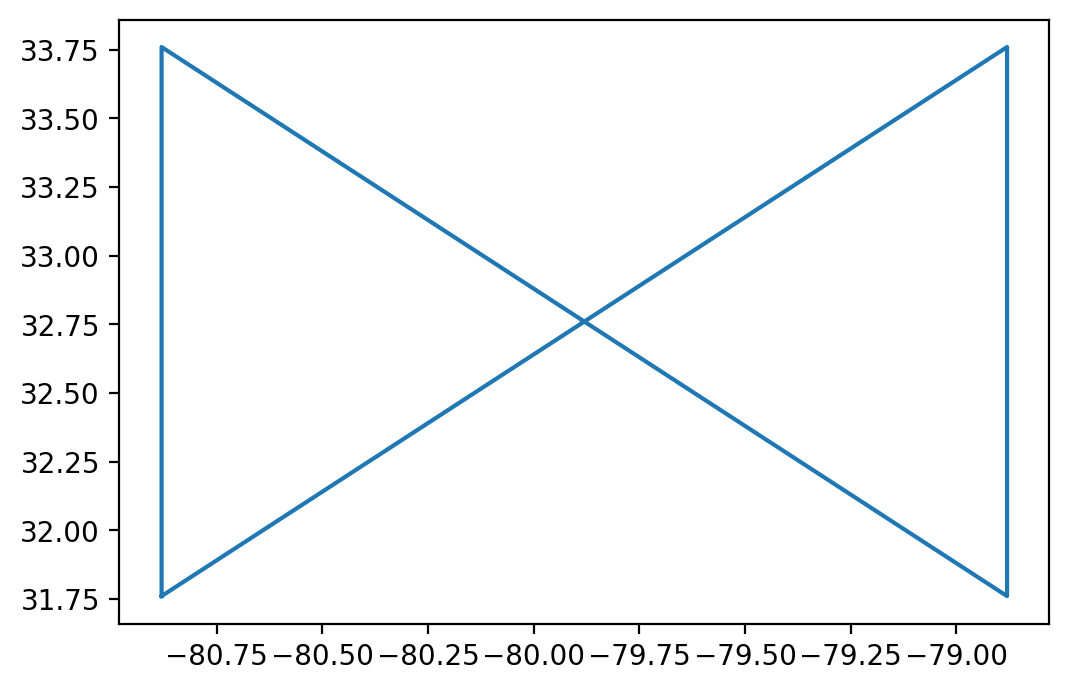

In [ ]:
x,y = polygon_geom.exterior.xy
plt.plot(x,y)

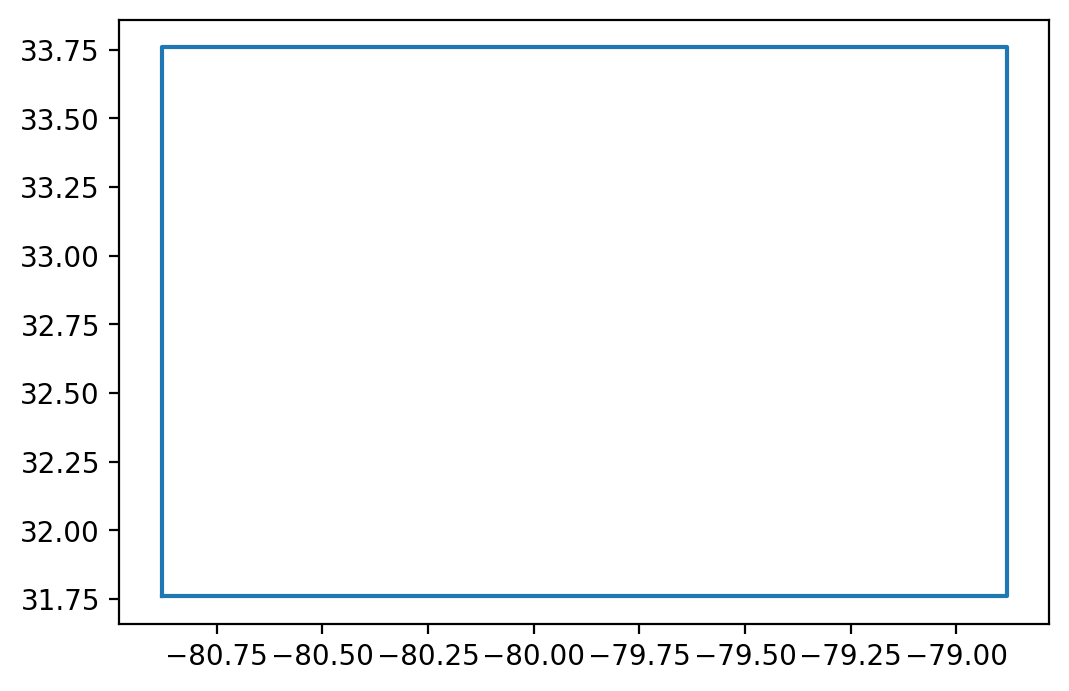

In [ ]:
x,y = polygon_geom.exterior.xy
plt.plot(x,y)

# Function for global flood risk


In [3]:
def download_flood_risk_data():
    """
    Downloads and unzips the flood risk data into the present working directory.
    """

    wget.download("https://cidportal.jrc.ec.europa.eu/ftp/jrc-opendata/FLOODS/GlobalMaps/floodMapGL_rp100y.zip")

    with zipfile.ZipFile("floodMapGL_rp100y.zip", 'r') as zip_ref:
        zip_ref.extractall(".")

In [9]:
def latlon_to_flood_risk(input_df: pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
    """
    Takes as input latlons in a pandas dataframe and returns the flood risk at each latlon. Functional globally.

    Values indicate water depth (in m).

    Parameter
    ---------
    df : pd.core.frame.DataFrame
        An n x 2 sized dataframe containing with the first column contain lat and the second column containing lon.

    Returns
    -------
    pd.core.frame.DataFrame
        A single pandas dataframe column giving the flood risk.
    """

    def rows_cols_to_flood_risk(df):
        """
        A simple function that takes the rows and columns in the supplied dataframe and gets the flood risk value from the appropriate map
        """

        # a window size of 1 is used in the image read; this returns a numpy array with one element, which is extracted with .item() function
        return image.read(1, window = rasterio.windows.Window(df.cols, df.rows, 1, 1)).item()

    # load images
    image = rasterio.open("./floodMapGL_rp100y.tif")

    # create a copy of the input dataframe. This is needed as extra columns are added and should not be added to the original dataframe
    df = input_df.copy()

    # create some blank columns
    df["rows"] = 0
    df["cols"] = 0
    df["flood_risk"] = 0

    # this names the columns lat and lon for clarity
    df.rename(columns = {list(df)[0]: 'lat'}, inplace = True)
    df.rename(columns = {list(df)[1]: 'lon'}, inplace = True)

    # convert latlons into row/column format
    df["rows"], df["cols"] = rasterio.transform.rowcol(image.transform, df.lon, df.lat)

    # loop through all row/columns and get the stormsurge value at that row/column
    df["flood_risk"] = df.apply(rows_cols_to_flood_risk, axis = 1)

    return(df[["flood_risk"]])

In [5]:
download_flood_risk_data()

In [10]:
df = pd.DataFrame([[25.956241, -80.377171], [26.032639, -80.343475], [26.099539, -80.363751], [26.102101, -80.150908], [25.996856, -80.152309], [25.829204, -80.233454], [26.825944, -80.740088], [26.816851, -80.678592]]) 

In [11]:
df[["flood_risk"]] = latlon_to_flood_risk(df)

In [12]:
df

,0,1,flood_risk
0,25.956241,-80.377171,-3.402823e+38
1,26.032639,-80.343475,-3.402823e+38
2,26.099539,-80.363751,-3.402823e+38
3,26.102101,-80.150908,-3.402823e+38
4,25.996856,-80.152309,-3.402823e+38
5,25.829204,-80.233454,-3.402823e+38
6,26.825944,-80.740088,3.000000e-01
7,26.816851,-80.678592,-3.402823e+38


In [ ]:
# https://data.jrc.ec.europa.eu/collection/id-0054

In [3]:
wget.download("https://cidportal.jrc.ec.europa.eu/ftp/jrc-opendata/FLOODS/GlobalMaps/floodMapGL_rp100y.zip") # resolution is 30 arcseconds (~ 1km)

'floodMapGL_rp100y.zip'

In [4]:
with zipfile.ZipFile("floodMapGL_rp100y.zip", 'r') as zip_ref:
    zip_ref.extractall(".")


In [2]:
image = rasterio.open("/content/floodMapGL_rp100y.tif")

In [8]:
display(image.meta)

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -3.4028230607370965e+38,
 'width': 41616,
 'height': 16468,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.008333333333333, 0.0, -166.79998779296875,
        0.0, -0.008333333333333, 83.22509765625)}

In [50]:
!rio info floodMapGL_rp100y.tif --verbose # more image metadata, including latlon, min, max, mean

/bin/bash: /usr/local/lib/libtinfo.so.6: no version information available (required by /bin/bash)
{"blockxsize": 128, "blockysize": 128, "bounds": [-166.79998779296875, -54.008235677077835, 180.0000122070174, 83.22509765625], "checksum": [10120], "colorinterp": ["gray"], "compress": "lzw", "count": 1, "crs": "EPSG:4326", "descriptions": [null], "driver": "GTiff", "dtype": "float32", "height": 16468, "indexes": [1], "interleave": "band", "lnglat": [6.600012207024321, 14.608430989586083], "mask_flags": [["nodata"]], "nodata": -3.4028230607370965e+38, "res": [0.008333333333333, 0.008333333333333], "shape": [16468, 41616], "stats": [{"max": 30.0, "mean": 3.48358281652, "min": 0.0099999997764826, "std": 4.9776433876454}], "tiled": true, "transform": [0.008333333333333, 0.0, -166.79998779296875, 0.0, -0.008333333333333, 83.22509765625, 0.0, 0.0, 1.0], "units": [null], "width": 41616}


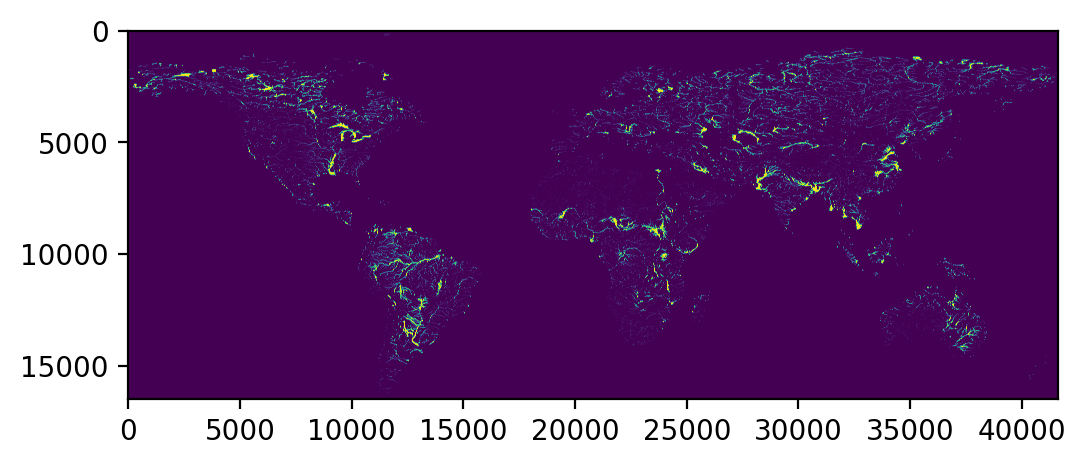

In [3]:
plt.imshow(image.read(1))
plt.show()

In [10]:
lat, lon = 32.076107, -80.998112   # this is a recognisable point on the coast of Puerto Rico, latlon taken from google maps

# the following function takes either floats or lists of floats (or numpy arrays) containing latlon coords, and outputs the rows/columns where those latlon values occur
rows, cols = rasterio.transform.rowcol(image.transform, lon, lat) # note that lat and lon have swapped: I don't know why, but it was way off unswapped
display(rows, cols)

6137

10296

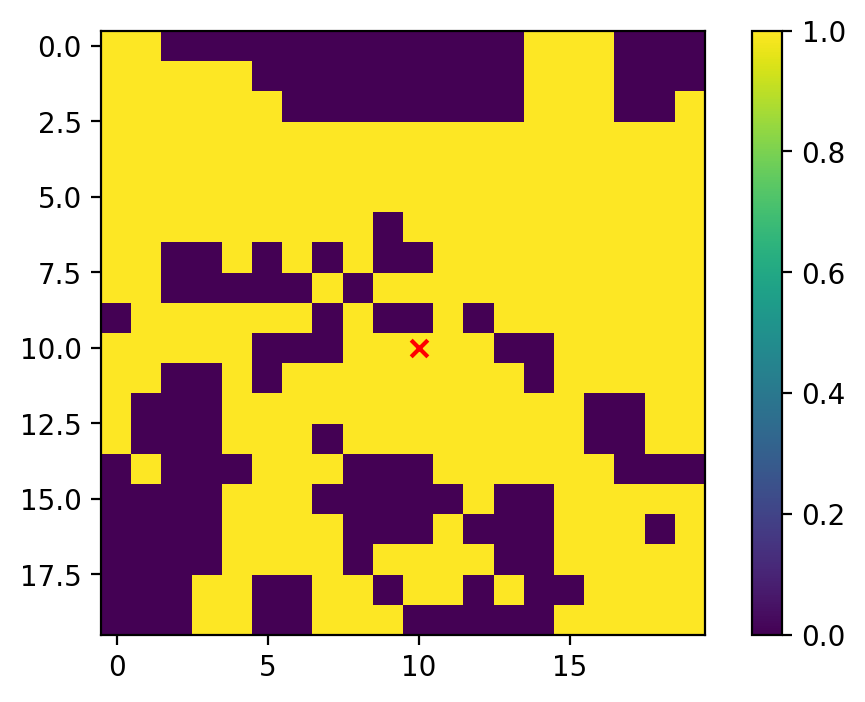

In [13]:
plt.imshow(image.read(1, window = rasterio.windows.Window(cols-10, rows-10, 20, 20)))
plt.scatter(10, 10, marker = "x", c = "red") # this point was chosen as it is very recognisable
plt.colorbar()
plt.show()

In [51]:
df = pd.DataFrame([[25.956241, -80.377171], [26.032639, -80.343475], [26.099539, -80.363751], [26.102101, -80.150908], [25.996856, -80.152309], [25.829204, -80.233454], [26.825944, -80.740088], [26.816851, -80.678592]]) 

In [52]:
df[["flood_risk", "rows", "cols"]] = latlon_to_flood_risk(df)

In [54]:
df

,0,1,flood_risk,rows,cols
0,25.956241,-80.377171,-3.402823e+38,6872,10370
1,26.032639,-80.343475,-3.402823e+38,6863,10374
2,26.099539,-80.363751,-3.402823e+38,6855,10372
3,26.102101,-80.150908,-3.402823e+38,6854,10397
4,25.996856,-80.152309,-3.402823e+38,6867,10397
5,25.829204,-80.233454,-3.402823e+38,6887,10387
6,26.825944,-80.740088,3.000000e-01,6767,10327
7,26.816851,-80.678592,-3.402823e+38,6768,10334


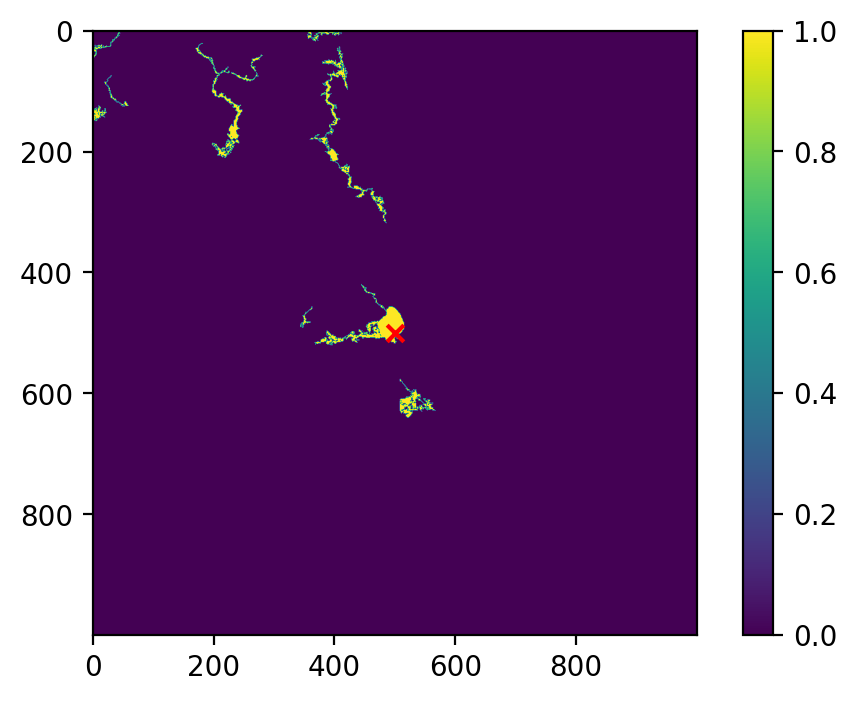

In [55]:
buffer = 500
plt.imshow(image.read(1, window = rasterio.windows.Window(10327-buffer, 6767-buffer, buffer*2, buffer*2)))
plt.scatter(buffer, buffer, marker = "x", c = "red") # The marker is right in the centre of Lake Okeechobee
plt.colorbar()
plt.show()

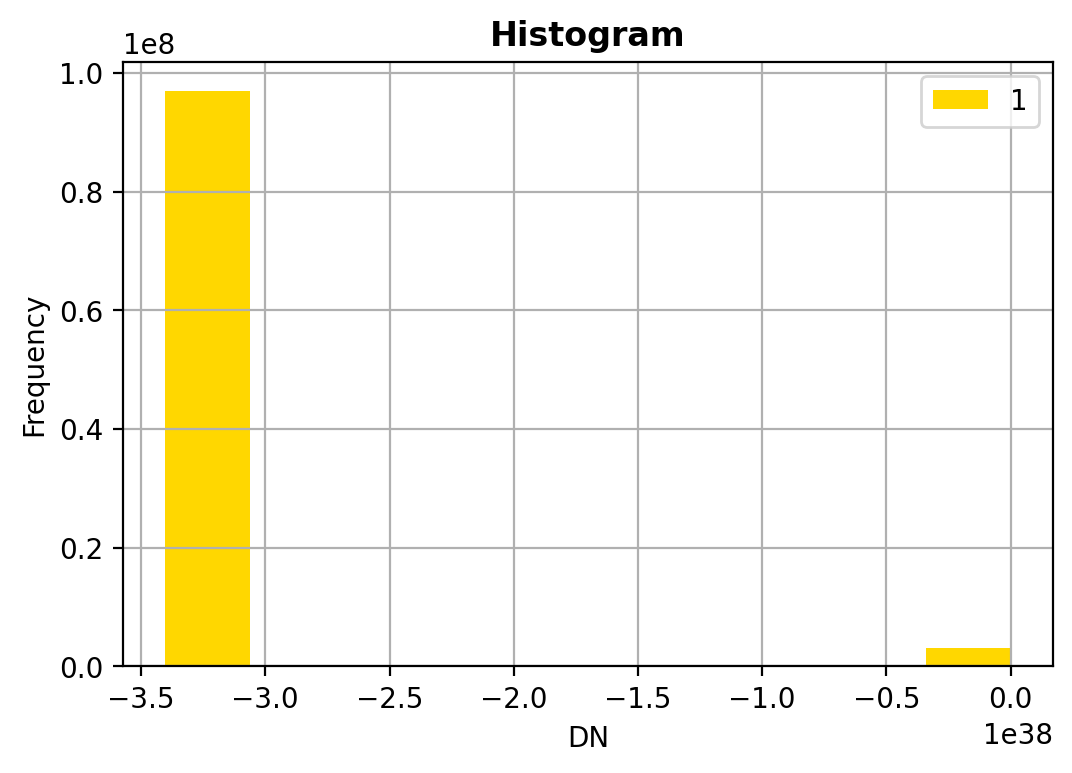

In [4]:
image = rasterio.open("/content/floodMapGL_rp100y.tif")

buffer = 5000
show_hist(image.read(1, window = rasterio.windows.Window(10327-buffer, 6767-buffer, buffer*2, buffer*2)))
plt.show()